# Three MA Strategy
The notebook implements a simple strategy decided by three Moving Averages Line. The strategy decision involves:
- Buy when 5-day period price cross from below to above the 20-day price when both are larger than 50-day price.
- Sell when 5-day period price cross from above to below 20-day price when both are smaller than 50-day price.

Afterall, result shows an increase in Sharpe Ratio, decrease in Maximum Drawdown and Maximum Drawdown Duration.
- Win-to-Lose Ratio of 1.067 
- Average Winning Percentage: 18.70%
- Average Losing Percentage: -7.44%

Given that the frequency of winning is greater than losing, and that average winning percentage is more than double the average losing perce

In [74]:
import numpy as np
import pandas as pd
import statistics as stats
import math
import matplotlib.pyplot as plt
import re

In [3]:
aapl_hist = pd.read_csv('AAPL.csv')
aapl_hist

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-07-18,24.674999,25.032499,24.650000,24.957500,23.314920,145975600
1,2016-07-19,24.889999,25.000000,24.834999,24.967501,23.324263,95119600
2,2016-07-20,25.000000,25.115000,24.934999,24.990000,23.345284,105104000
3,2016-07-21,24.957500,25.250000,24.782499,24.857500,23.221504,130808000
4,2016-07-22,24.815001,24.825001,24.577499,24.665001,23.041672,113254800
...,...,...,...,...,...,...,...
1254,2021-07-12,146.210007,146.320007,144.000000,144.500000,144.500000,76299700
1255,2021-07-13,144.029999,147.460007,143.630005,145.639999,145.639999,100827100
1256,2021-07-14,148.100006,149.570007,147.679993,149.149994,149.149994,127050800
1257,2021-07-15,149.240005,150.000000,147.089996,148.479996,148.479996,106820300


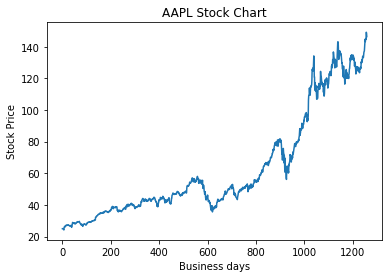

In [5]:
plt.plot(aapl_hist.loc[:,'Close'])
plt.ylabel('Stock Price')
plt.title('AAPL Stock Chart')
plt.xlabel('Business days')

plt.show()

## Sharpe Ratio

Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Volatility is a measure of the price fluctuations of an asset or portfolio. The Sharpe ratio can help you determine the investment choice that will deliver the highest returns while considering risk.

In [87]:
'''Function calculates Sharpe Ratio of an investing strategy. Function takes holding history, risk-free rate 
and investment duration as agruments. By default, invest duration is set to 0, which means that investment 
duration is should be the same as the holding period'''

def sharpe_ratio(hold_hist, riskfree_rate, invest_dura = 0):
    # if invest_dura == 0, find invest duration based on holding history
    if invest_dura == 0:
        invest_dura = len(hold_hist)
        
    excess_return = [0]
    for i in range(len(hold_hist) - 1):
        today_price = float(hold_hist.at[i+1, 'Close'])
        yesterday_price = float(hold_hist.at[i, 'Close'])
        ret = (today_price - yesterday_price)/yesterday_price
    
        # append to excess return list
        excess_return.append(ret - riskfree_rate/invest_dura) 
    
    mean = stats.mean(excess_return)
    std = stats.stdev(excess_return)
    
    sharpe = mean/std*math.sqrt(invest_dura)
    print('Sharpe Ratio:',sharpe)
    return sharpe

## Maximum Drawdown

A maximum drawdown (MDD) is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained. Maximum drawdown is an indicator of downside risk over a specified time period.

In [88]:
'''Function calculates Maximum Drawdown and Maximum Drawdown Duration of an investing strategy. Function takes
holding history as its only input agrument and returns MDD and MDD duration'''

def mdd(hold_hist):
    mdd = 0
    curr_mdd = 0
    mdd_duration = 0
    curr_mdd_duration = 0

    curr_trough = hold_hist.at[0,'Close'] 
    curr_peak = hold_hist.at[0,'Close']    
    curr_peak_date = ''
    curr_trough_date = ''
    final_peak_date = ''
    final_trough_date = ''
    
    final_peak_value = 0
    final_trough_value = 0
    
    for i in range(len(hold_hist)):
        # set new peak if current price higher than current peak and calculate current mdd
        if hold_hist.at[i,'Close'] > curr_peak:
            curr_mdd = (curr_trough - curr_peak)/curr_peak
            if curr_mdd_duration > mdd_duration:
                mdd_duration = curr_mdd_duration
                final_peak_date = curr_peak_date
                final_trough_date = curr_trough_date
            curr_mdd_duration = 0

            # if current mdd smaller than overall mdd, set new minimum mdd
            if curr_mdd < mdd:
                mdd = curr_mdd
                final_peak_value = curr_peak
                final_trough_value = curr_trough
            
            curr_peak = hold_hist.at[i,'Close']
            curr_peak_date = hold_hist.at[i,'Date']
            curr_trough = hold_hist.at[i,'Close']
            curr_trough_date = hold_hist.at[i,'Date']
                
        # set new trough if current price lower than current trough
        elif hold_hist.at[i,'Close'] <= curr_trough:
            curr_trough = hold_hist.at[i,'Close']
            curr_trough_date = hold_hist.at[i,'Date']

            curr_mdd_duration += 1
        else:
            curr_mdd_duration += 1

    print(f'MDD: {mdd*100}% \t resulting from {final_peak_value} to {final_trough_value}')
    print(f'MDD Duration: {mdd_duration} business days \t from {final_peak_date} to {final_trough_date}')

    return mdd, mdd_duration

## Moving Average

In [89]:
def simple_moving_average(hold_hist):
    periods = {5: [], 20: [], 50: []}
    for period in periods:
        for i in range(len(hold_hist)):
            if i < period:
                periods[period].append(np.nan)
            else:
                last_prices = []
                for j in range(period):
                    last_prices.append(hold_hist.at[i-j,'Close'])
                periods[period].append(stats.mean(last_prices))
    return periods

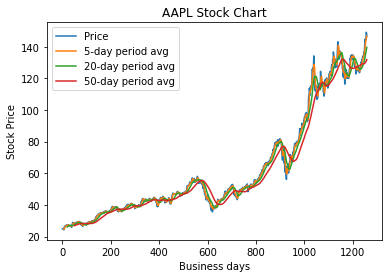

In [27]:
# Plot stock chart along with its movin average
periods = simple_moving_average(aapl_hist)

plt.plot(aapl_hist.loc[:,'Close'], label='Price')
plt.ylabel('Stock Price')
plt.title('AAPL Stock Chart')
plt.xlabel('Business days')
plt.plot(periods[5][:],label='5-day period avg')
plt.plot(periods[20][:],label='20-day period avg')
plt.plot(periods[50][:],label='50-day period avg')

plt.legend()

Buying and Selling Strategy:
- Buy when 5-day period price cross from below to above the 20-day price when both are larger than 50-day price.
- Sell when 5-day period price cross from above to below 20-day price when both are smaller than 50-day price.

In [90]:
'''3 Moving-Average Buy Sell Strategy'''

def three_ma(hold_hist):
    hold_result = []
    hold_plot = []
    
    is_holding = False
    periods = simple_moving_average(hold_hist)
    print('Buy and Sell Transactions:\n')

    for i in range(51, len(hold_hist)):     
        # buy when 5-period MA greater than 20-period MA while both are greater than 50-period MA
        if periods[5][i] > periods[20][i] and periods[5][i] > periods[50][i] and periods[20][i] > periods[50][i] and is_holding == False:
            #periods[5][i-2] < periods[20][i-2]
            hold_result.append(i)
            hold_plot.append(i)
            is_holding = True
            print(f"Buy on day {hold_hist.at[i,'Date']}")
        # sell when 5-period MA smaller than 20-period MA while both are smaller than 50-period MA
        elif periods[5][i] < periods[20][i] and periods[5][i] < periods[50][i] and periods[20][i] < periods[50][i] and is_holding == True:
            #periods[5][i-2] > periods[20][i-2] and
            is_holding = False
            hold_plot.append(0)
            print(f"Sell on day {hold_hist.at[i,'Date']}")
        elif is_holding:
            hold_result.append(i)   
            hold_plot.append(i)
        else:
            hold_plot.append(0)

            
    return hold_hist.iloc[hold_result,:].reset_index(), hold_hist.iloc[hold_plot,:].reset_index()

In [62]:
new_df, new_plot_df = three_ma(aapl_hist)

Buy and Sell Transactions:

Buy on day 2016-09-28
Sell on day 2016-11-15
Buy on day 2016-12-22
Sell on day 2017-06-27
Buy on day 2017-08-02
Sell on day 2017-10-02
Buy on day 2017-11-01
Sell on day 2018-02-06
Buy on day 2018-03-08
Sell on day 2018-04-24
Buy on day 2018-05-10
Sell on day 2018-10-29
Buy on day 2019-02-12
Sell on day 2019-05-24
Buy on day 2019-07-01
Sell on day 2020-03-05
Buy on day 2020-04-30
Sell on day 2020-10-23
Buy on day 2020-11-10
Sell on day 2021-02-26
Buy on day 2021-04-19
Sell on day 2021-05-26
Buy on day 2021-06-28


Text(0.5, 1.0, 'Applied Strategy - AAPL Stock Chart')

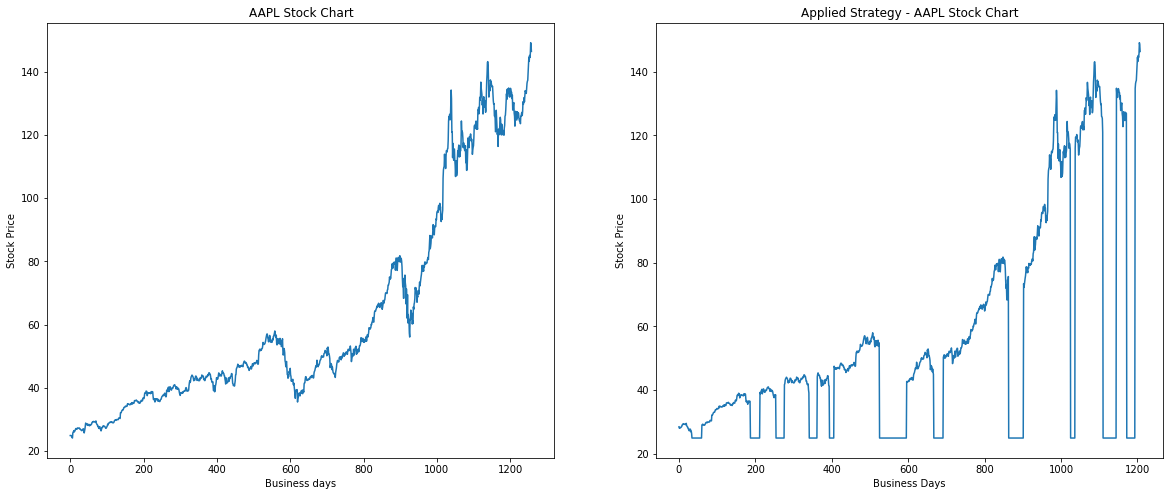

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.plot(aapl_hist.loc[:,'Close'])
ax1.set_ylabel('Stock Price')
ax1.set_title('AAPL Stock Chart')
ax1.set_xlabel('Business days')

ax2.plot(new_plot_df['Close'])
ax2.set_ylabel('Stock Price')
ax2.set_xlabel('Business Days')
ax2.set_title('Applied Strategy - AAPL Stock Chart')

In [27]:
print('Before applying strategy, holding from the start to till end of period:')
sharpe_ratio(aapl_hist, 0)
mdd(aapl_hist)

print('\n=====================================================================\n')
print('Strategy applied:')
sharpe_ratio(new_df, 0)
mdd(new_df)

Before applying strategy, holding from the start to till end of period:
Sharpe Ratio: 2.954467336345958
MDD: -38.729694015436934% 	 resulting from 58.017502 to 35.547501
MDD Duration: 256 business days 	 from 2018-10-03 to 2019-01-03


Strategy applied:
Sharpe Ratio: 28.775973554825327
MDD: -26.668683529325342% 	 resulting from 58.017502 to 42.544998
MDD Duration: 160 business days 	 from 2018-10-03 to 2019-02-13


(-0.26668683529325343, 160)

In [102]:
'''Function evaluates win/lose ratio as well as average winning, losing percentage. Function takes transaction history
as inputs and prints out the desired ratio'''

def evaluate_win_lose_ratio(new_df):
    streaks = []
    streak = []
    # seperate transactions into streaks
    for i in range(len(new_df) - 1):
        if new_df.at[i,'index'] + 1 == new_df.at[i+1,'index']:
            streak.append(i)
        else:
            streaks.append(streak)
            streak = []

    win_percent = []
    lose_percent = []

    def calculate_percent(begin_price, end_price):
        return (end_price - begin_price)/begin_price

    # decide whether a streak is a win or lose, then find the mean of winning and losing percentages
    for streak in streaks:
        price_change = calculate_percent(new_df.at[streak[0],'Close'],new_df.at[streak[-1],'Close'])
        if price_change > 0:
            win_percent.append(price_change)
        else:
            lose_percent.append(price_change)
        
    print(f'Win count: {len(win_percent)}')
    print(f'Lose count: {len(lose_percent)}\n')
    print(f'Win/Lose Ratio: {len(win_percent)/len(lose_percent)}')
    print(f'Winning Average: {stats.mean(win_percent)*100} %')
    print(f'Losing Average: {stats.mean(lose_percent)*100} %')
    
    return win_percent, lose_percent

In [58]:
evaluate_win_lose_ratio(new_df)

Win count: 6
Lose count: 5

Win/Lose Ratio: 1.2
Winning Average: 26.526232464897525 %
Losing Average: -4.642154809655404 %


In [103]:
def three_ma_full(hold_hist, stock_name):
    new_df, new_plot_df = three_ma(hold_hist)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    # Plot compairing stock price chart and transaction chart
    ax1.plot(hold_hist.loc[:,'Close'])
    ax1.set_ylabel('Stock Price')
    ax1.set_title(f'{stock_name} Stock Chart')
    ax1.set_xlabel('Business days')

    ax2.plot(new_plot_df['Close'])
    ax2.set_ylabel('Stock Price')
    ax2.set_xlabel('Business Days')
    ax2.set_title(f'Applied Strategy - {stock_name} Stock Chart')
    
    print('\n=====================================================================\n')

    # Evaluation metric 1: Sharpe ratio and Maximum Drawdown
    print('Before applying strategy, holding from the start to till end of period:')
    sharpe_ratio(hold_hist, 0)
    mdd(hold_hist)

    print('\n*********************************************************************\n')

    print('Strategy applied:')
    sharpe_ratio(new_df, 0)
    mdd(new_df)
    
    print('\n=====================================================================\n')

    # Evalution metric 2: Win/Lose Ratio and Win/Lose Percentage
    win, lose = evaluate_win_lose_ratio(new_df)
    return win, lose

Buy and Sell Transactions:

Buy on day 2016-09-28
Sell on day 2016-11-15
Buy on day 2016-12-22
Sell on day 2017-06-27
Buy on day 2017-08-02
Sell on day 2017-10-02
Buy on day 2017-11-01
Sell on day 2018-02-06
Buy on day 2018-03-08
Sell on day 2018-04-24
Buy on day 2018-05-10
Sell on day 2018-10-29
Buy on day 2019-02-12
Sell on day 2019-05-24
Buy on day 2019-07-01
Sell on day 2020-03-05
Buy on day 2020-04-30
Sell on day 2020-10-23
Buy on day 2020-11-10
Sell on day 2021-02-26
Buy on day 2021-04-19
Sell on day 2021-05-26
Buy on day 2021-06-28


Before applying strategy, holding from the start to till end of period:
Sharpe Ratio: 2.954467336345958
MDD: -38.729694015436934% 	 resulting from 58.017502 to 35.547501
MDD Duration: 256 business days 	 from 2018-10-03 to 2019-01-03

*********************************************************************

Strategy applied:
Sharpe Ratio: 28.775973554825327
MDD: -26.668683529325342% 	 resulting from 58.017502 to 42.544998
MDD Duration: 160 business day

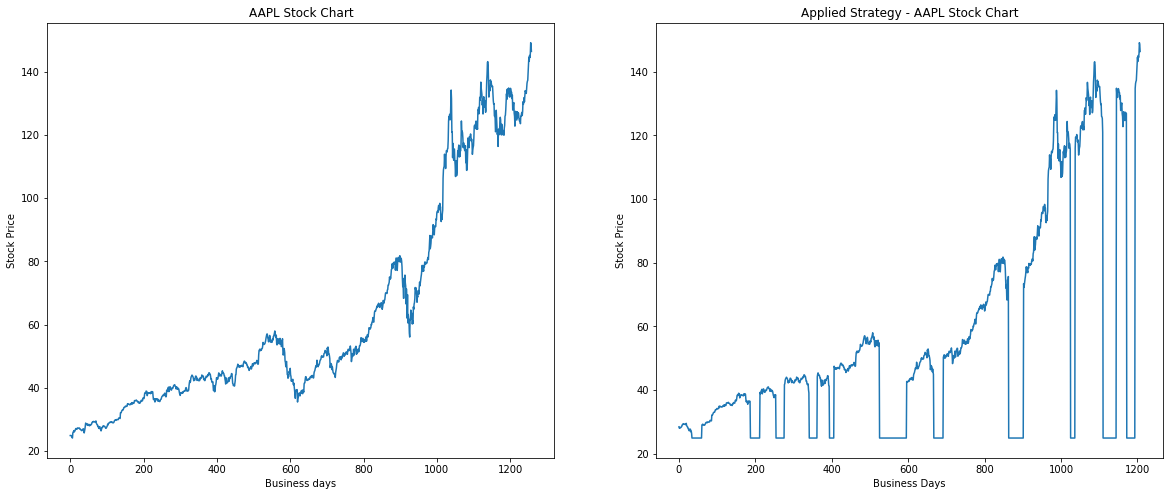

In [67]:
three_ma_full(aapl_hist, 'AAPL')

Buy and Sell Transactions:

Buy on day 2010-03-18
Sell on day 2010-06-11
Buy on day 2010-06-18
Sell on day 2010-07-22
Buy on day 2010-09-20
Sell on day 2011-04-06
Buy on day 2011-05-12
Sell on day 2011-05-27
Buy on day 2011-07-14
Sell on day 2011-11-17
Buy on day 2011-12-28
Sell on day 2012-05-09
Buy on day 2012-06-25
Sell on day 2012-10-17
Buy on day 2013-05-17
Sell on day 2013-06-26
Buy on day 2013-07-31
Sell on day 2014-01-28
Buy on day 2014-03-26
Sell on day 2014-04-22
Buy on day 2014-04-25
Sell on day 2014-10-17
Buy on day 2014-10-28
Sell on day 2015-01-05
Buy on day 2015-02-05
Sell on day 2015-06-25
Buy on day 2015-10-27
Sell on day 2015-12-18
Buy on day 2016-03-11
Sell on day 2016-05-05
Buy on day 2016-07-25
Sell on day 2016-11-15
Buy on day 2016-12-22
Sell on day 2017-06-27
Buy on day 2017-08-02
Sell on day 2017-10-02
Buy on day 2017-11-01
Sell on day 2018-02-06
Buy on day 2018-03-08
Sell on day 2018-04-24
Buy on day 2018-05-10
Sell on day 2018-10-29
Buy on day 2019-02-12
Sell 

Win count: 16
Lose count: 9

Win/Lose Ratio: 1.7777777777777777
Winning Average: 10.18087616507144 %
Losing Average: -4.708232261460548 %
Buy and Sell Transactions:

Buy on day 1999-07-20
Sell on day 1999-08-04
Buy on day 1999-10-12
Sell on day 2000-04-25
Buy on day 2000-06-28
Sell on day 2000-10-09
Buy on day 2000-12-29
Sell on day 2001-02-28
Buy on day 2001-05-01
Sell on day 2001-06-20
Buy on day 2001-10-22
Sell on day 2002-01-29
Buy on day 2002-03-20
Sell on day 2002-04-22
Buy on day 2002-08-19
Sell on day 2002-09-20
Buy on day 2002-11-05
Sell on day 2002-12-26
Buy on day 2003-03-31
Sell on day 2003-08-07
Buy on day 2003-08-26
Sell on day 2003-10-13
Buy on day 2003-11-03
Sell on day 2004-04-15
Buy on day 2004-09-10
Sell on day 2005-01-13
Buy on day 2005-02-09
Sell on day 2005-04-15
Buy on day 2005-07-05
Sell on day 2006-01-04
Buy on day 2006-01-23
Sell on day 2006-05-23
Buy on day 2006-08-10
Sell on day 2007-03-08
Buy on day 2007-04-16
Sell on day 2007-06-28
Buy on day 2007-09-25
Se

IndexError: list index out of range

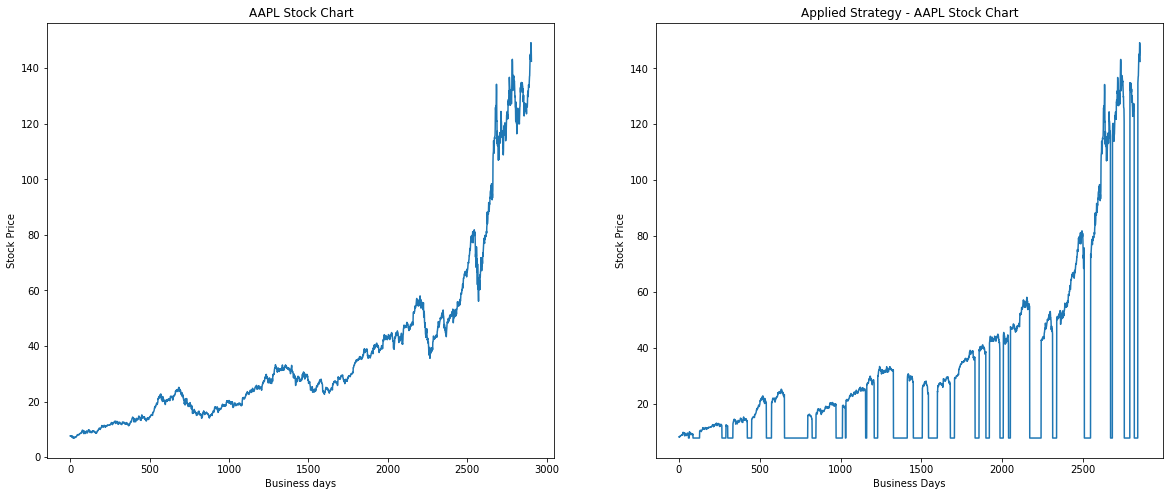

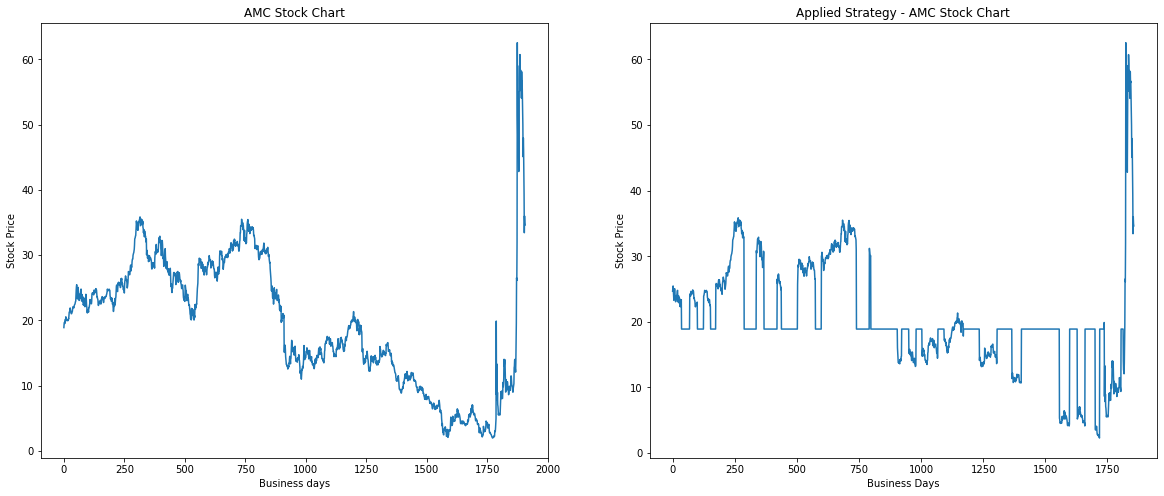

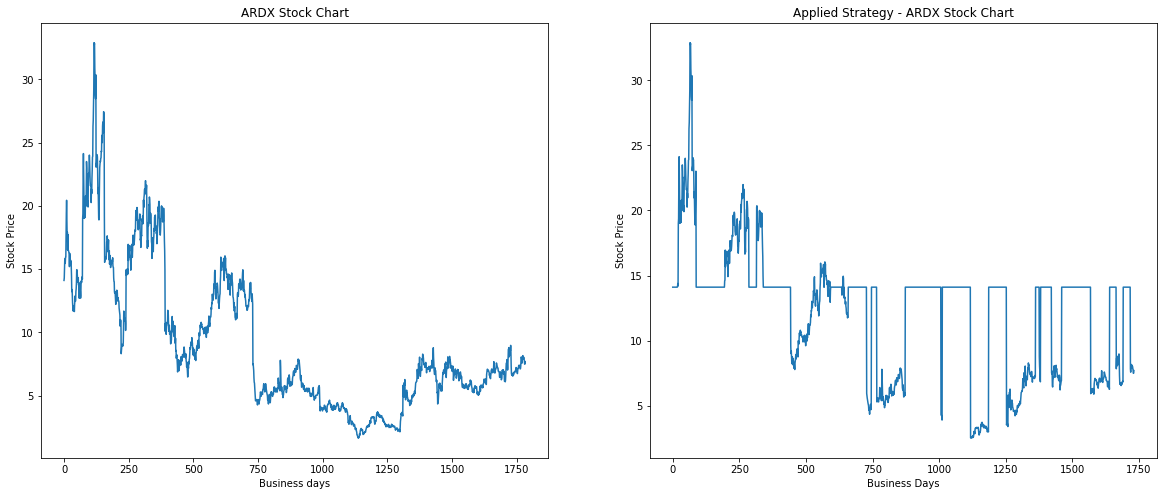

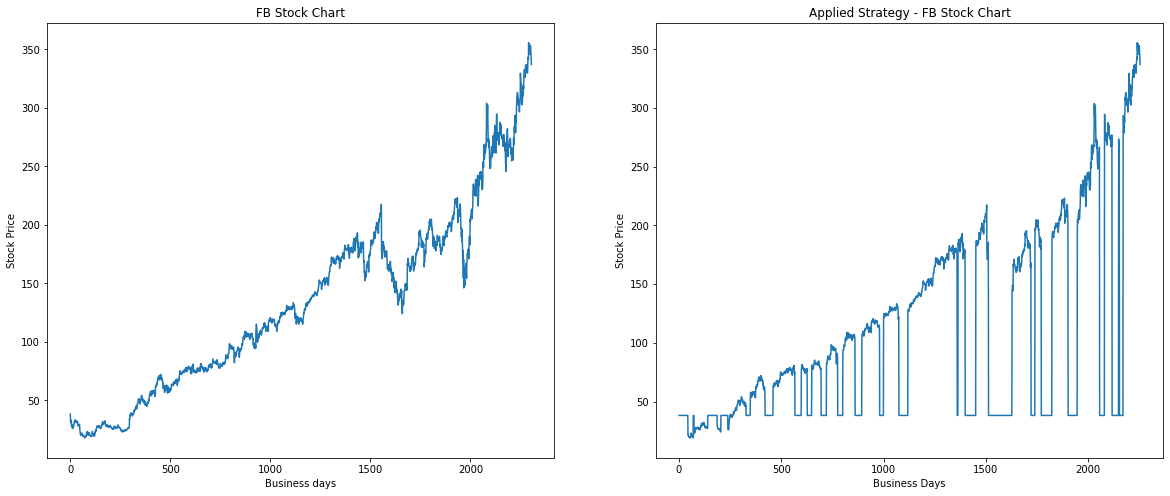

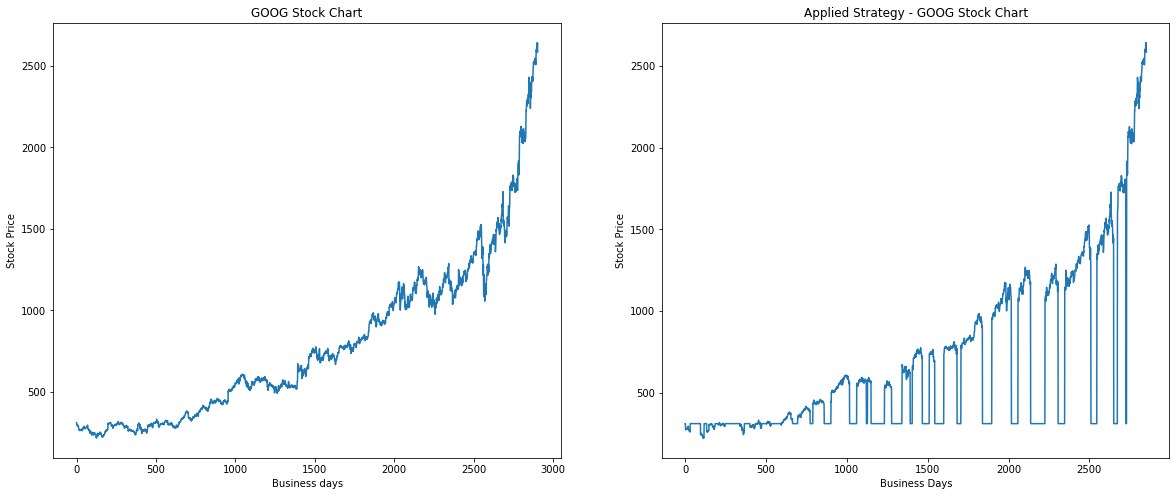

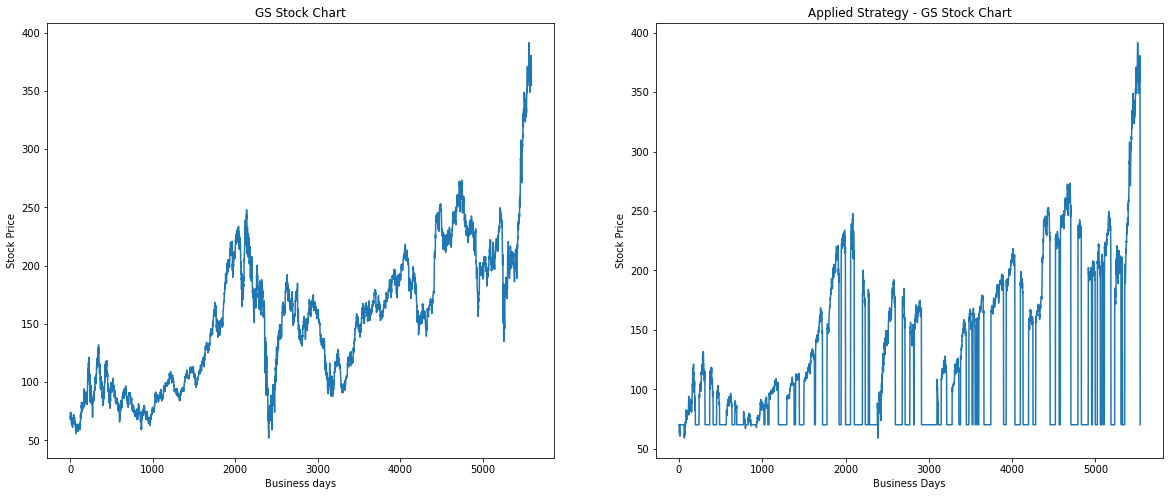

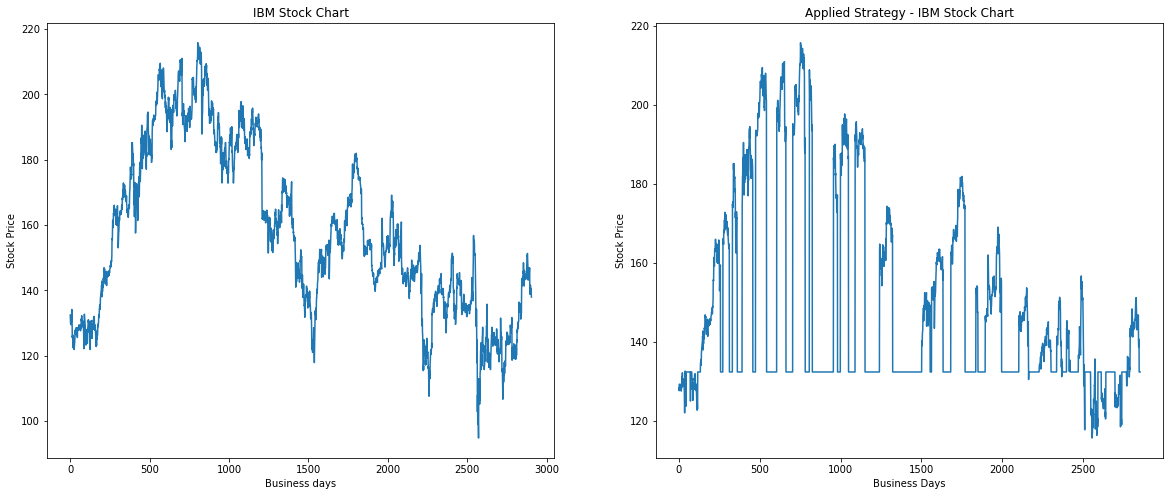

In [109]:
# Read stocks data
csv_files = ['AAPL.csv','AMC.csv','ARDX.csv','FB.csv','GOOG.csv','GS.csv','IBM.csv','JNJ.csv','NVAX.csv','NVDA.csv','TSLA.csv']
win_percents = []
lose_percents = []

for csv_file in csv_files:
    stock_name = re.sub('.csv','',csv_file)
    df_file = pd.DataFrame()
    df_file = pd.read_csv(csv_file)
    wins, loses = three_ma_full(df_file, stock_name)
    for win in wins:
        win_percents.append(win)
    for lose in loses:
        lose_percents.append(lose)

In [111]:
print(f'Win count: {len(win_percents)}')
print(f'Lose count: {len(lose_percents)}\n')
print(f'Win/Lose Ratio: {len(win_percents)/len(lose_percents)}')
print(f'Winning Average: {stats.mean(win_percents)*100} %')
print(f'Losing Average: {stats.mean(lose_percents)*100} %')

Win count: 79
Lose count: 74

Win/Lose Ratio: 1.0675675675675675
Winning Average: 18.703294847501745 %
Losing Average: -7.44076676604993 %
